<a href="https://colab.research.google.com/github/codeavenger456/MNIST_Max-digits/blob/main/Modified_without_generator.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install kaggle

In [2]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 70 bytes


In [3]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [4]:
! kaggle competitions download -c mais-202-fall-2020-kaggle-competition

  0% 0.00/341k [00:00<?, ?B/s]
100% 341k/341k [00:00<00:00, 49.4MB/s]
 98% 770M/784M [00:04<00:00, 201MB/s]
100% 784M/784M [00:04<00:00, 183MB/s]
 95% 187M/196M [00:01<00:00, 174MB/s]
100% 196M/196M [00:01<00:00, 139MB/s]


In [5]:
! unzip train_x.npy.zip
! unzip test_x.npy.zip

Archive:  train_x.npy.zip
  inflating: train_x.npy             
Archive:  test_x.npy.zip
  inflating: test_x.npy              


In [123]:
import numpy as np
train_images = np.load("train_x.npy")

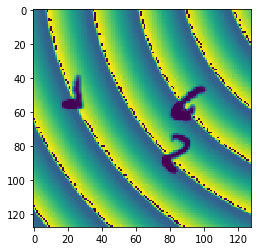

In [124]:
import matplotlib.pyplot as plt

def show_image(arr):
    two_d = (np.reshape(arr, (128, 128)) * 255).astype(np.uint8)
    plt.imshow(two_d, interpolation='nearest')
    plt.show()

show_image(train_images[0]) # 0 is the index of the training image you want to display

Import Libraries 

In [145]:
import cv2
import numpy as np
import pandas as pd
from keras.layers import Dense, Flatten, BatchNormalization, Activation, MaxPool2D, Dropout, Convolution2D, AveragePooling2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.convolutional import Conv2D
from keras.models import Sequential
from keras.utils import to_categorical
from keras.optimizers import RMSprop, Adam, SGD, Adadelta
import matplotlib.pyplot as plt
import copy
from sklearn.model_selection import train_test_split

# CNN architecture

Get our Dataset 

In [127]:
# use train_image instead it x_train has been previously loaded
y_train = pd.read_csv('train_y.csv')
#discard the Id column from the np array we dont need it
y_train = y_train["Label"]
x_test = np.load('test_x.npy')
# the batch picture generator only takes in categorical tuple data for some reason so we will do this
y_train = to_categorical(y_train)

In [128]:
x_test_sample= train_images[:-100]
y_test_sample = y_train[:-100]
train_images = train_images[-100:]
y_train = y_train[-100:]

Data augmentation and put them together in graysacle and horizontally

In [129]:
from google.colab.patches import cv2_imshow
from scipy import ndimage
def data_process(image):
  processed = (image > 210) * 255
  #cv2_imshow(processed)
  processed = ndimage.median_filter(processed, size=2)
  #cv2_imshow(processed)
  return processed

**Conversion**

In [130]:
for image in train_images:
  image = data_process(image)
for image in x_test_sample:
  image = data_process(image)

In [131]:
train_images = train_images.reshape(train_images.shape[0], train_images.shape[1], train_images.shape[2], 1)
x_test_sample = np.expand_dims(x_test_sample, axis=-1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)

Split training dataset into training and validation dataset

In [132]:
X_train, X_val, Y_train, Y_val = train_test_split(train_images, y_train, test_size=0.1)

CNN network

In [149]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
        activation='relu',
        input_shape=(128,128,1)))
model.add(Dropout(0.2))
model.add(Conv2D(32, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(Dropout(0.2))
model.add(Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dropout(0.25))
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_54 (Conv2D)           (None, 126, 126, 32)      320       
_________________________________________________________________
dropout_26 (Dropout)         (None, 126, 126, 32)      0         
_________________________________________________________________
conv2d_55 (Conv2D)           (None, 126, 126, 32)      9248      
_________________________________________________________________
max_pooling2d_18 (MaxPooling (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_56 (Conv2D)           (None, 63, 63, 64)        18496     
_________________________________________________________________
dropout_27 (Dropout)         (None, 63, 63, 64)        0         
_________________________________________________________________
conv2d_57 (Conv2D)           (None, 63, 63, 64)      

In [150]:
model.compile(loss="categorical_crossentropy",
				  optimizer=Adadelta(),
				  metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=25, validation_data=(X_val, Y_val))

Epoch 1/25
3/3 [==============================] - 1s 248ms/step - loss: 20.0950 - accuracy: 0.0889 - val_loss: 6.1493 - val_accuracy: 0.0000e+00
Epoch 2/25
3/3 [==============================] - 0s 46ms/step - loss: 16.6511 - accuracy: 0.1111 - val_loss: 5.4779 - val_accuracy: 0.1000
Epoch 3/25
3/3 [==============================] - 0s 47ms/step - loss: 15.8314 - accuracy: 0.0778 - val_loss: 4.9479 - val_accuracy: 0.1000
Epoch 4/25
3/3 [==============================] - 0s 46ms/step - loss: 16.4358 - accuracy: 0.0667 - val_loss: 4.5772 - val_accuracy: 0.1000
Epoch 5/25
3/3 [==============================] - 0s 47ms/step - loss: 15.7582 - accuracy: 0.1333 - val_loss: 4.2662 - val_accuracy: 0.1000
Epoch 6/25
3/3 [==============================] - 0s 47ms/step - loss: 15.0909 - accuracy: 0.0667 - val_loss: 4.1101 - val_accuracy: 0.1000
Epoch 7/25
3/3 [==============================] - 0s 48ms/step - loss: 13.5309 - accuracy: 0.1444 - val_loss: 3.7825 - val_accuracy: 0.2000
Epoch 8/25
3/3 

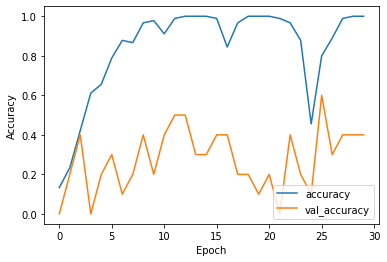

In [135]:
plt.plot(history.history["accuracy"], label="accuracy")
plt.plot(history.history["val_accuracy"], label="val_accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

In [102]:
datagen = ImageDataGenerator(
    rotation_range=20,
    zoom_range = 0.2,
    width_shift_range = 0.2,
    height_shift_range = 0.2,
    shear_range = 0.15
)
datagen.fit(X_train)

In [103]:
model2 = Sequential()
    
model2.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu', input_shape=(128, 128, 1)))
model2.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(Conv2D(32, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(Conv2D(64, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(Conv2D(128, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(Conv2D(256, kernel_size=(3, 3), padding="same", activation='relu'))
model2.add(BatchNormalization())
model2.add(MaxPool2D(pool_size=(2, 2)))
model2.add(Dropout(0.2))

model2.add(Flatten())
model2.add(Dense(512, activation='relu'))
model2.add(Dense(512, activation='relu'))
model2.add(Dropout(0.5))
model2.add(Dense(10, activation='softmax'))

model2.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_12 (Conv2D)           (None, 128, 128, 32)      320       
_________________________________________________________________
conv2d_13 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
conv2d_14 (Conv2D)           (None, 128, 128, 32)      9248      
_________________________________________________________________
batch_normalization_4 (Batch (None, 128, 128, 32)      128       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 64, 64, 32)        0         
_________________________________________________________________
dropout_5 (Dropout)          (None, 64, 64, 32)        0         
_________________________________________________________________
conv2d_15 (Conv2D)           (None, 64, 64, 64)       

In [105]:
model2.compile(loss="categorical_crossentropy", optimizer=RMSprop(), metrics=['accuracy'])
history2 = model2.fit_generator(datagen.flow(X_train, Y_train, batch_size=200), validation_data=(X_val, Y_val), epochs=30)

Epoch 1/30
1/1 [==============================] - 0s 375ms/step - loss: 4.0943 - accuracy: 0.0778 - val_loss: 169.1661 - val_accuracy: 0.4000
Epoch 2/30
1/1 [==============================] - 0s 165ms/step - loss: 27.5130 - accuracy: 0.2222 - val_loss: 21779.4004 - val_accuracy: 0.1000
Epoch 3/30
1/1 [==============================] - 0s 167ms/step - loss: 35.3479 - accuracy: 0.2222 - val_loss: 36157.5742 - val_accuracy: 0.1000
Epoch 4/30
1/1 [==============================] - 0s 164ms/step - loss: 23.8347 - accuracy: 0.2000 - val_loss: 14699.6660 - val_accuracy: 0.1000
Epoch 5/30
1/1 [==============================] - 0s 165ms/step - loss: 22.9558 - accuracy: 0.2333 - val_loss: 38992.1797 - val_accuracy: 0.4000
Epoch 6/30
1/1 [==============================] - 0s 165ms/step - loss: 15.2767 - accuracy: 0.1889 - val_loss: 71560.5156 - val_accuracy: 0.1000
Epoch 7/30
1/1 [==============================] - 0s 161ms/step - loss: 9.5012 - accuracy: 0.1889 - val_loss: 23398.4121 - val_accura

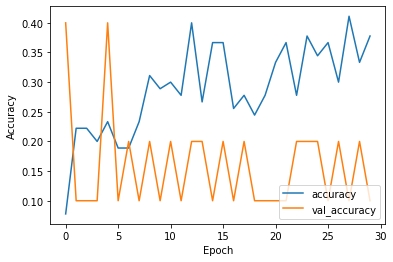

In [106]:
plt.plot(history2.history["accuracy"], label="accuracy")
plt.plot(history2.history["val_accuracy"], label="val_accuracy")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.show()

Predicting the results

In [ ]:
labels_probabilities = model.predict(x_test)
labels = np.argmax(labels_probabilities, axis=1)
print(labels)

See the predictions

In [ ]:
for i in labels:
  print(i)

Put in CSV

In [ ]:
ids = [i for i in range(len(labels))]
ids = np.array(ids)
df = pd.DataFrame({'Id':ids, 'Label': labels})
df.to_csv('prediction.csv', index=False)